# Week 6: Models for multimodal data integration 

**Authors: Jana Braunger & Britta Velten**

In this notebook, you will learn how to use some of the multi model data integration methods discussed in the lecture. It consists of three main parts:
1. Application of MOFA to a multi-omics data set (gene expression, methylation, mutations and drug responses)
2. Application of MEFISTO to a longitudinal data set (gene expression measurement samples over developmental time in multiple species and organs)
3. Using pyro to implement your own factor model

First, we need to install some additional packages: 

In [1]:
!pip install dtw-python
!pip install scanpy==1.9.3
!pip install muon
!pip install mofax
!pip install mofapy2
!pip install pyro-ppl

# Application of MOFA to a multi-omics data set

The following section shows how to use the `muon` package to apply the factor model MOFA to integrate multi-omics data. The code is based on [this](https://muon-tutorials.readthedocs.io/en/latest/CLL.html) tutorial. We apply MOFA to a multi-omics data set, in which various data modalities have been measured in primary cancer cells of 200 individual patients with chronic lymphocytic leukemia (CLL). For more details on the data please see a detailed analysis in the [original publication](https://www.huber.embl.de/pub/pdf/Dietrich2018.pdf).

In [2]:
# Required packages
import scanpy as sc
import muon as mu
import numpy as np
import pandas as pd
import mofax as mofa
import seaborn as sns

/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/janabraunger/anaconda3/envs/sc/lib/python3.10/site-packag

## Load data

Count matrices and metadata of the multi-omics CLL study are publicly available as part of the [MOFAdata R package](http://bioconductor.org/packages/release/data/experiment/html/MOFAdata.html). For the purpose of this notebook, those matrices were saved in individual `.csv` files in the `data/` folder. Please make sure to add this folder to your local directory. The data set consists of the following four modalities:  
1. mRNA: normalized expression of 5000 variable genes
2. methylation: methylation state of 4248 CpG locations
3. mutations: occurrence of insertions or deletions at 69 DNA regions
4. drugs: ex vivo drug sensitivity measurements for 310 drugs

In [3]:
# Create dictionary of AnnData objects (one per modality)
data_dir = "data/"
mods = {i:sc.AnnData(pd.read_csv(f"{data_dir}{i}.csv", index_col=0).T) 
        for i in ("mRNA", "methylation", "mutations", "drugs")}
mods

{'mRNA': AnnData object with n_obs × n_vars = 200 × 5000,
 'methylation': AnnData object with n_obs × n_vars = 200 × 4248,
 'mutations': AnnData object with n_obs × n_vars = 200 × 69,
 'drugs': AnnData object with n_obs × n_vars = 200 × 310}

The data per modality is stored in the `AnnData` format (more infos about the Anndata structure [here](https://anndata.readthedocs.io/en/latest/)). This format is typically also used in single cell analysis, e.g. by the package `scanpy`. The value matrices can be accessed using `.X`, the row names are stored under `.obs_names` and the column names under `.var_names`. Let's explore how the input data of the mRNA modality looks like:

In [4]:
print("First sample names: ", mods['mRNA'].obs_names[0:5].tolist())
print("First gene names: ", mods['mRNA'].var_names[0:5].tolist())
print("Values: ", mods['mRNA'].X[0:5, 0:5])
print("Mean: ", np.mean(mods['mRNA'].X[[0]]), ", Variance: ", np.var(mods['mRNA'].X[[0]]))

First sample names:  ['H045', 'H109', 'H024', 'H056', 'H079']
First gene names:  ['ENSG00000244734', 'ENSG00000158528', 'ENSG00000198478', 'ENSG00000175445', 'ENSG00000174469']
Values:  [[ 4.55864355 11.74185387  8.92145552 12.6864583   2.6449457 ]
 [ 2.72151227 13.28743173  2.72151227 10.92598507 12.64835536]
 [ 9.9384557   2.34100585 12.38145198  1.52884845  1.52884845]
 [13.27800449  3.23287407  8.10626625  1.52884845 13.56521029]
 [ 6.08687386 11.94081968  4.88950293 13.34058824  5.47691374]]
Mean:  6.18622345321868 , Variance:  12.791719513892316


**Excercise:** Explore how the data matrices of the other modalities look like. Based on this, which likelihood distributions would you choose for each modality for training a MOFA model?

**Solution**

The mRNA, methylation and drug modality are continuous values, which is why we choose a Gaussian likelihood prior. However, the mutation matrix only contains 0s and 1s. Therefore, a Bernoulli likelihood should be chosen for the mutations. 

In [5]:
print("First mutation names: ", mods['mutations'].var_names[0:5].tolist())
print("Values: ", mods['mutations'].X[0:5, 0:5])

print("First methlation names: ", mods['methylation'].var_names[0:5].tolist())
print("Values: ", mods['methylation'].X[0:5, 0:5])

print("First drug names: ", mods['drugs'].var_names[0:5].tolist())
print("Values: ", mods['drugs'].X[0:5, 0:5])

First mutation names:  ['gain2p25.3', 'gain3q26', 'del6p21.2', 'del6q21', 'del8p12']
Values:  [[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]
First methlation names:  ['cg10146935', 'cg26837773', 'cg17801765', 'cg13244315', 'cg06181703']
Values:  [[ 1.81108585 -5.17257225  5.41152631 -0.11882508  5.12038376]
 [-3.99750846  1.59487016  5.41269253  1.04387064  1.27948028]
 [-2.84431298  0.16117049  0.36570594 -4.21923622  0.7211004 ]
 [-3.33865611 -2.09343256  0.37363417 -1.59219648  4.04705939]
 [-0.01936203  3.74897956  5.41200957  1.41641834  5.23742246]]
First drug names:  ['D_001_1', 'D_001_2', 'D_001_3', 'D_001_4', 'D_001_5']
Values:  [[0.02363938 0.04623274 0.31874706 0.82370272 0.89627769]
 [0.073599   0.10623002 0.2732891  0.71713794 0.88500034]
 [       nan        nan        nan        nan        nan]
 [0.0581393  0.09022028 0.23221452 0.72257364 0.79574966]
 [0.02042077 0.04750543 0.36389622 0.80739074 0.87948865]]


Next, we are creating a data frame with some additional information about each patient which includes:
- Gender: m (male), f (female)
- Age: age in years
- TTT: time (in years) between taking the sample to the next treatment
- TTD: time (in years) between taking the sample to patients' death
- treatedAfter: True/False indicating whether patient has been treated
- Died: True/False indicating whether the patient died

In [6]:
# load meta data information
CLL_metadata = pd.read_csv("ftp://ftp.ebi.ac.uk/pub/databases/mofa/cll_vignette/sample_metadata.txt", 
                           sep="\t", index_col="sample")
CLL_metadata.head()

,Gender,age,TTT,TTD,treatedAfter,died,IGHV,trisomy12
sample,,,,,,,,
H005,m,75.265753,0.574949,2.625599,True,False,1.0,0.0
H006,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H007,f,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H008,m,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H010,f,72.780822,2.932238,2.932238,False,False,0.0,0.0


To create a multi-modal data object from the dictionary containing the four single modalities, we use the package `muon`. `muon` allows to directly run MOFA on this `MuData` object. If you want to learn more about `muon`, check out its [documentation](https://muon.readthedocs.io/en/latest/notebooks/quickstart_mudata.html) or [paper](https://link.springer.com/article/10.1186/s13059-021-02577-8).

In [7]:
mdata = mu.MuData(mods)
# add metadata
mdata.obs = mdata.obs.join(CLL_metadata)
mdata

MuData object with n_obs × n_vars = 200 × 9627
  obs:	'Gender', 'age', 'TTT', 'TTD', 'treatedAfter', 'died', 'IGHV', 'trisomy12'
  4 modalities
    mRNA:	200 x 5000
    methylation:	200 x 4248
    mutations:	200 x 69
    drugs:	200 x 310

## Integrate data

**Multi-omics factor analysis** (MOFA) integration can be run on a MuData object with a single command:
 
```
mu.tl.mofa()
```

In case some samples are missing from some of the modalities, as they are in this CLL dataset, `muon` can be instructed to handle it. One of two modes has to be chosen for that:

1. `use_obs='union'`, which will populate values for missing samples in certain modalities with NAs, or

1. `use_obs='intersection'`, which will use a subset of samples that are present in all modalities.

We will use the first option here. Additionally, we have to specify how many latent factors should be inferred which is set to 15 in this example. With these settings we can now train a MOFA model which takes a few minutes to run.

In [8]:
mu.tl.mofa(mdata, use_obs='union', 
           n_factors=15, convergence_mode='medium',
           outfile="models/CLL_union.hdf5")


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='mRNA' group='group1' with N=200 samples and D=5000 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the f

## Interpret intergrated data

Let's have a look at the model output and analyse what is captured in the latent factors. For this, we are using the `mofax` package to load our trained model and then plot the amount of variance that each factor explains across the data modalities.

In [9]:
# load trained MOFA model
model = mofa.mofa_model("models/CLL_union.hdf5")
model

MOFA+ model: CLL union
Samples (cells): 200
Features: 9627
Groups: group1 (200)
Views: drugs (310), mRNA (5000), methylation (4248), mutations (69)
Factors: 15
Expectations: W, Z

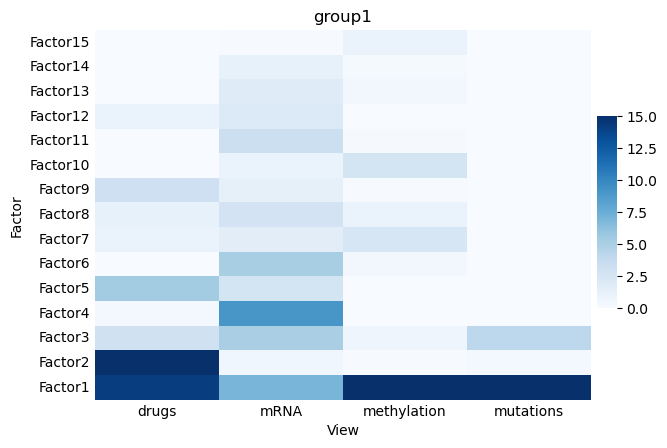

In [10]:
# variance decomposition
mofa.plot_r2(model, x='View', vmax=15)

We notice e.g. that `Factor 1` captures variability across all modalities, whereas `Factor 2` and `Factor 4` are quite specific to one modality, drugs and mRNA respectively.

**Excercise**: Train another MOFA model using only 5 factors. How much of the total variance per view can be explained with the new model compared to the existing one? Hint: use the function model.get_r2()

In [11]:
# Solution
# Train MOFA model with 5 factors
mu.tl.mofa(mdata, use_obs='union',
           n_factors=5, convergence_mode='medium',
           outfile="models/CLL_union_5f.hdf5")

# load trained MOFA model
model_5f = mofa.mofa_model("models/CLL_union_5f.hdf5")

# Total variance explained for the model with 5 factors
total_f5 = model_5f.get_r2().groupby(['View']).sum()
total_f5['n_factors'] = 5

# Total variance explained for the model with 15 factors
total_f15 = model.get_r2().groupby(['View']).sum()
total_f15['n_factors'] = 15
total_variance = pd.concat([total_f5, total_f15]).reset_index()



        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='mRNA' group='group1' with N=200 samples and D=5000 features...
Loaded view='methylation' group='group1' with N=200 samples and D=4248 features...
Loaded view='mutations' group='group1' with N=200 samples and D=69 features...
Loaded view='drugs' group='group1' with N=200 samples and D=310 features...


Model options:
- Automatic Relevance Determination prior on the f

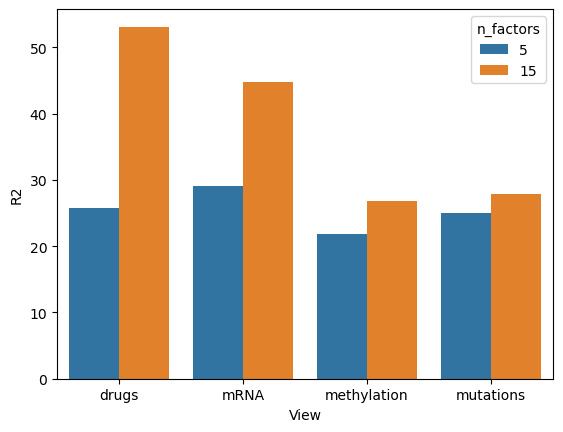

In [12]:
sns.barplot(total_variance, x = 'View', y = 'R2', hue = 'n_factors');

Using a factor model with 15 instead of 5 factor leads to an increase in the total explained variability of all modalities. Especially, in the drugs and mRNA modality additional factors seem to capture additional sources of variability that would be lost in a model using only 5 factors. Therefore, we are focusing in this tutorial on the model with 15 factors.

Next, we can plot our samples in the learned latent space. For this, we can use the `plot_factors` function which allows to choose the latent factors to plot, as well as a covariate from the metadata for coloring.   

<Axes: title={'center': 'Gender'}, xlabel='Factor1', ylabel='Factor2'>

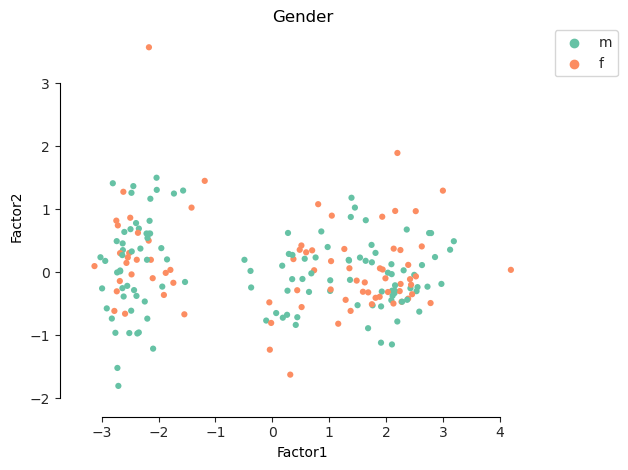

In [13]:
# Plotting the samples in the learned factor space 
mofa.plot_factors(model, x = "Factor1", y="Factor2",  size=20, color = "Gender")

Factor 1 seems to separate the patients into 2 groups. Since males and females are well mixed in this plot, variability between gender doesn't seem to be captured in Factor 1 nor Factor 2.

**Excercise:** How does the plot look like for other factors? Try out some combinations of factors and other coloring choices to check whether some of the covariates are linked to the values of a factor. (`model.metadata` can be used to look at the available metadata information for coloring)

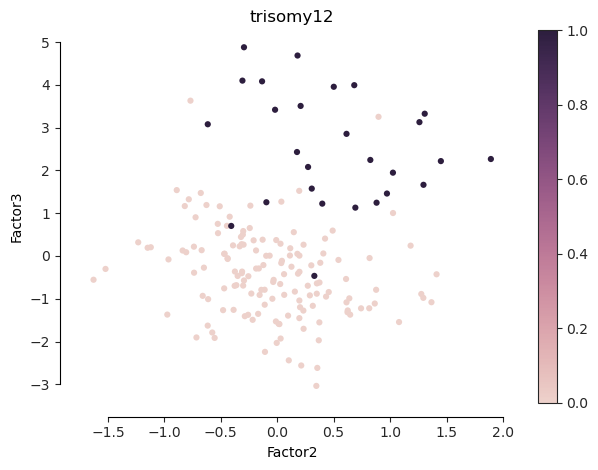

In [14]:
# Solution example: looking at factor 2 and 3, coloring according to Trisomy12 label
mofa.plot_factors(model, x = "Factor2", y="Factor3",  size=20, color = "trisomy12");

### Factor 1

Let's explore which features are driving the differences across patients in factor 1. For this, we look at the feature weights in the MOFA model and label the ones with highest absolute weights.

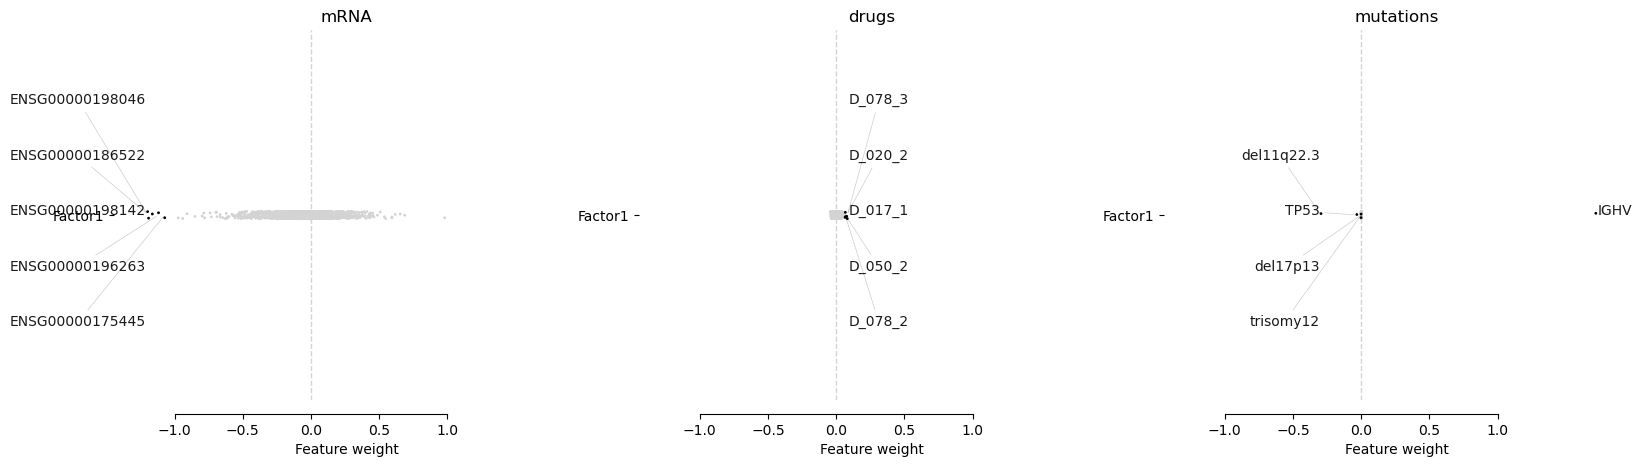

In [15]:
mofa.plot_weights(model, views=['mRNA', 'mutations', 'drugs'], factors=0, zero_line=True, ncols=3, label_size=10);

We can see that in the mutations modality IGHV has a much higher absolute weight than all other features. Additionally, the top weights from the RNA modality are likely to represent the same latent process as IGHV status:

- ENSG00000198046 &rarr; ZNF667 — lnc‐ZNF667‐AS1 [is associated with poor survival and is a promising prognostic biomarker](https://onlinelibrary.wiley.com/doi/abs/10.1111/ijlh.13167)

- ENSG00000186522 &rarr; SEPT10 – its expression [correlates with IGHV status](https://www.nature.com/articles/2404220) (however [there are some caveats](https://www.nature.com/articles/2404867))

- ENSG00000198142 &rarr; SOWAHC – it [has been identified as a prognostic marker for other cancers](https://www.spandidos-publications.com/mmr/21/3/1285)

Focusing on the drug response, we notice PF477736 (D_078), AZD7762 (D_020), AT13387 (D_017), and dasatinib (D_050) have the major association with this factor. Those are the exact top associations with the IGHV status [described in the original paper](https://www.huber.embl.de/pub/pdf/Dietrich2018.pdf).

Let's check how the factor plot we created before looks like when we color it according to IGHV status.

<Axes: title={'center': 'IGHV'}, xlabel='Factor1', ylabel='Factor2'>

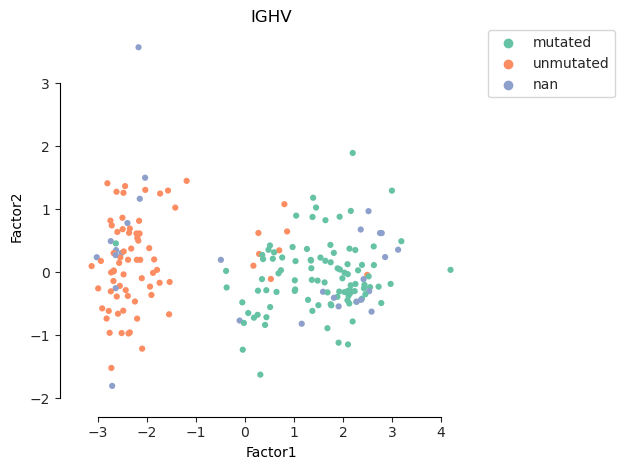

In [16]:
# Coloring the samples according to IGHV status
model.metadata.IGHV = (
    model.metadata.IGHV.astype(str).
        replace({'1.0': 'mutated', '0.0': 'unmutated'}).
        astype('category').cat.reorder_categories(["mutated", "unmutated", "nan"])
)

mofa.plot_factors(model, x = "Factor1", y="Factor2",  size=20, color = "IGHV")

So, the two clusters along the Factor1 axis nicely separate the patients based on whether they have the IGHV mutation and this seems the major factor of variation across patients in this CLL dataset. 

### Factor 3

Next, we like to perform a similar analysis for factor 3 since this factor also captures variability which is shared across multiple modalities.   
**Excercise:** Explore the weights in the different modalities of factor 3 to figure out its biological interpretation (remember to use `factors = 2` since the counting starts at 0).

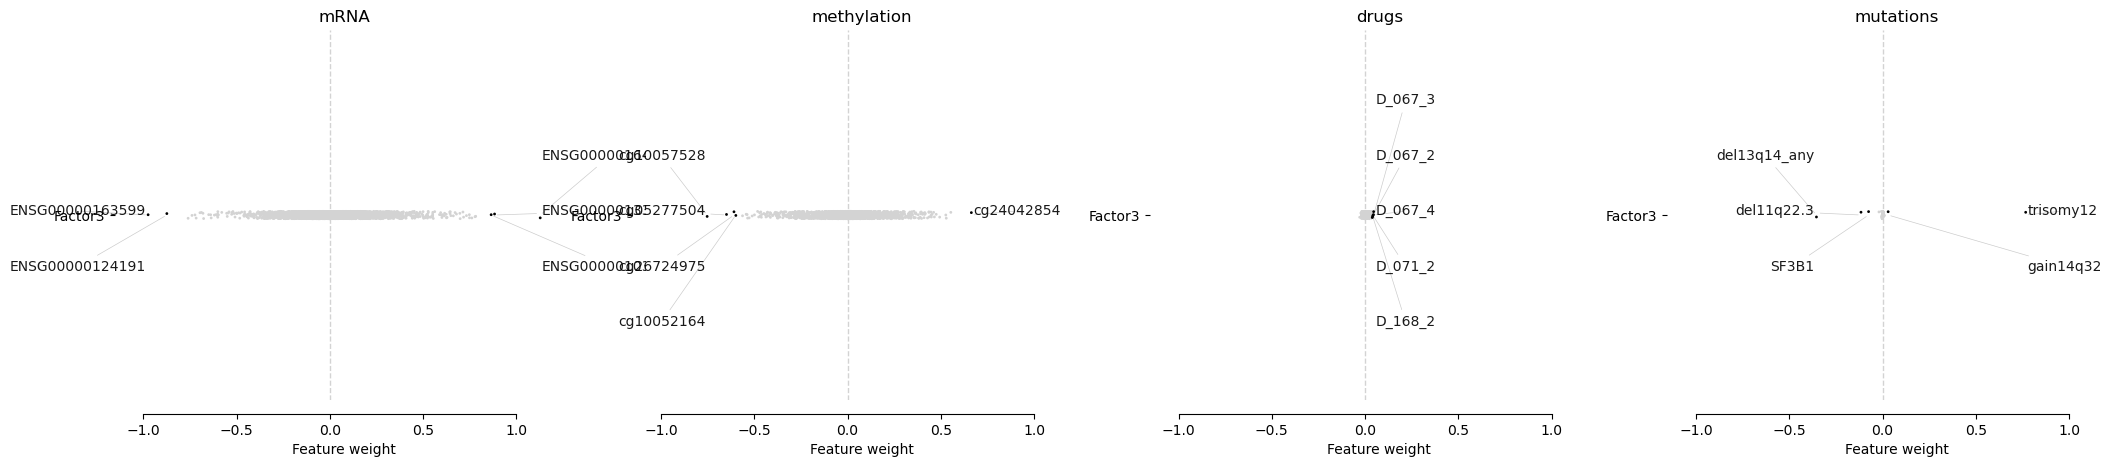

In [17]:
# Solution
mofa.plot_weights(model, factors=2, zero_line=True, label_size=10);

Looking at the feature weights in the mutations, we can see that `trisomy12` has the highest absolute weight in this factor. Let's plot the distribution of factor 3 values grouping the patients based on their trisomy 12 status. 

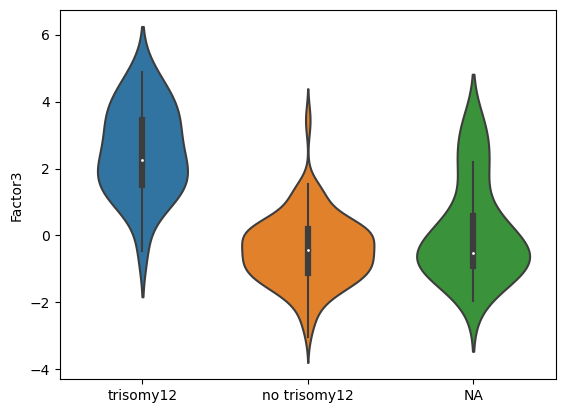

In [18]:
model.metadata.trisomy12 = (
    model.metadata.trisomy12.astype(str).
        replace({'1.0': 'trisomy12', '0.0': 'no trisomy12', 'nan': 'NA'}).
        astype('category').cat.reorder_categories(['trisomy12', 'no trisomy12', 'NA'])
)

# use mofax package to get data frames of the factor 3 values
f3 = model.get_factors(factors=2, df=True).join(model.metadata.trisomy12)
sns.violinplot(f3, x = 'trisomy12', y = 'Factor3').set(xlabel = None);

Short side note: in addition to the `get_factors` function, the mofax package contains the `get_weights` function to obtain the weight matrix for specified latent factors. These function allow to extract the inferred matrices of the model in case one likes to perform any additional user-specific analyses.

### Combinations of factors

Summarizing our results of what we have learned from interpreting factor 1 and 3 values, it seems like that a couple of major factors associated with differences in the drug response assay seem to capture molecular profiles of patients. Therefore, it might be useful for better understanding the drug response in CLL patients, to group patients according to their somatic mutations status (IGHV and trisomy12).

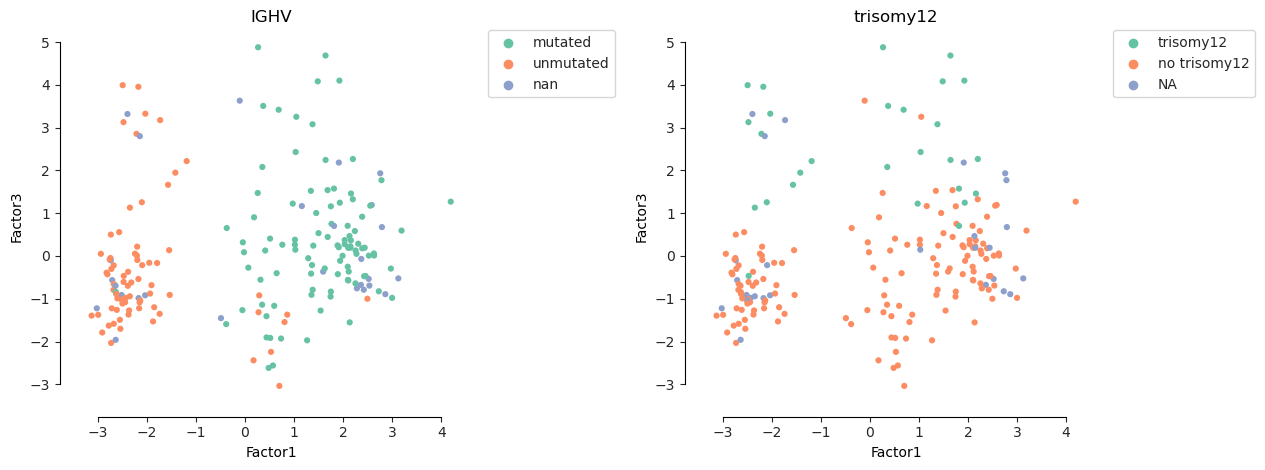

In [19]:
mofa.plot_factors(model, x=0, y=2, color=["IGHV", "trisomy12"], size=20,  palette="Set2");

# Application of MEFISTO to a longitudinal data set

Currently, an increasing number of multi omics data sets is created in which the samples are not indepently from each other but contain some known relationships between them. Examples for this would be collecting samples over multiple time points or in a spatial manner. For this purpose, the MOFA extension MEFISTO which is based on Gaussian Processes (for details see the lecture material) has been developed. In the following section, we are going to apply MEFISTO to an evodevo dataset in which gene expression has been measured in samples from 5 different species in 5 organs across developmental time (from embryonic development to adulthood). The code of this section is based on [this](https://muon-tutorials.readthedocs.io/en/latest/mefisto/1-MEFISTO-evodevo.html) tutorial. 

## Load data

First we will load the evodevo data containing normalized gene expression data for the 5 species (groups of the model: Human, Mouse, Rat, Rabbit and Opossum) and 5 organs (views of the model: Brain, Cerebellum, Heart, Liver and Testis) as well as the developmental time information for each sample. Note that in this data set only one modality (gene expression) has been measured, but we are instead treating the organs as different views of the model in this scenario. Please download the `evodevo.csv` data [from here](https://figshare.com/s/242916198fde3353f3e6) and save it in your data folder or use wget.


In [20]:
data = pd.read_csv("data/evodevo.csv", sep=",", index_col=0)
data

,group,view,sample,feature,value,time
1,Human,Brain,10wpc_Human,ENSG00000000457_Brain,8.573918,7
2,Human,Brain,10wpc_Human,ENSG00000001084_Brain,8.875957,7
3,Human,Brain,10wpc_Human,ENSG00000001167_Brain,11.265237,7
4,Human,Brain,10wpc_Human,ENSG00000001461_Brain,7.374965,7
5,Human,Brain,10wpc_Human,ENSG00000001561_Brain,7.311018,7
...,...,...,...,...,...,...
3193836,Human,Testis,youngMidAge_Human,ENSG00000271503_Testis,1.178014,21
3193837,Human,Testis,youngMidAge_Human,ENSG00000271601_Testis,1.178014,21
3193838,Human,Testis,youngMidAge_Human,ENSG00000272442_Testis,4.476201,21
3193839,Human,Testis,youngMidAge_Human,ENSG00000272886_Testis,1.178014,21


As you can see in the above data frame, the samples are here time points in various species at which a measurement has been taking during their development (wpc = weeks post conception). Since multiple species are used, we use the multi-group framework of MOFA, in which a group-specific factor matrix is learned.

To read the data into muon, we again first create a dictionary containing an AnnData object for each organ. Since the data is in long format, we first convert it to a wide data frame (samples x features). For instance, here's the data for the `'Brain'` view:

In [21]:
brain = data[data.view == 'Brain'].pivot(index='sample', columns='feature', values='value')
brain

feature,ENSG00000000457_Brain,ENSG00000001084_Brain,ENSG00000001167_Brain,ENSG00000001461_Brain,ENSG00000001561_Brain,ENSG00000001617_Brain,ENSG00000001629_Brain,ENSG00000001631_Brain,ENSG00000002549_Brain,ENSG00000002745_Brain,...,ENSG00000267909_Brain,ENSG00000268104_Brain,ENSG00000269058_Brain,ENSG00000270885_Brain,ENSG00000271092_Brain,ENSG00000271503_Brain,ENSG00000271601_Brain,ENSG00000272442_Brain,ENSG00000272886_Brain,ENSG00000273079_Brain
sample,,,,,,,,,,,,,,,,,,,,,
10wpc_Human,8.573918,8.875957,11.265237,7.374965,7.311018,9.959839,10.542619,9.692082,9.180280,4.281878,...,7.221091,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,11.74615
11wpc_Human,8.439675,8.737682,10.855314,8.066544,7.354726,10.431113,10.308780,9.242115,9.350255,3.363064,...,7.116983,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,1.421384,1.178014,11.28160
12wpc_Human,8.399178,8.916387,12.555510,9.253555,8.763702,9.946536,11.530929,10.033949,9.278142,4.322361,...,4.000716,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,2.664630,1.178014,13.97646
13wpc_Human,8.637347,8.831740,10.916489,9.190959,8.158240,10.279600,11.287268,9.510370,9.033614,4.784136,...,5.635512,1.178014,1.481758,1.178014,1.178014,1.178014,1.178014,1.776655,1.178014,12.47349
16wpc_Human,8.525125,8.575862,11.271736,8.177629,7.857303,10.363036,11.402954,9.523244,8.833177,2.785827,...,6.119527,1.178014,1.178014,1.178014,1.178014,1.178014,1.178014,2.413222,1.178014,13.73805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
senior_Human,8.437410,9.898419,8.216911,11.504150,9.958047,6.857990,9.623469,9.205518,9.884420,4.484028,...,3.862928,1.178014,2.254255,1.178014,1.178014,1.178014,1.178014,2.581292,1.178014,11.67438
teenager_Human,8.429526,9.949921,8.637132,11.680140,10.211020,6.452668,10.214710,9.604091,9.903370,5.265158,...,3.162686,1.178014,1.178014,1.178014,1.453269,1.178014,1.178014,3.016177,1.178014,12.54986
toddler_Human,8.333979,10.027860,8.693345,11.691260,9.731870,7.191969,10.286670,8.958592,10.120610,5.322412,...,5.152286,1.178014,1.648489,1.178014,1.178014,1.178014,1.178014,3.201100,1.178014,12.81460


In [22]:
# Create dictionary of AnnData objects per view
views = data.view.unique()
data_list = [data[data.view == m].pivot(index='sample', columns='feature', values='value') for m in views]
mods = {views[m]:sc.AnnData(data_list[m]) for m in range(len(views))}
mods

{'Brain': AnnData object with n_obs × n_vars = 83 × 7696,
 'Cerebellum': AnnData object with n_obs × n_vars = 83 × 7696,
 'Heart': AnnData object with n_obs × n_vars = 83 × 7696,
 'Liver': AnnData object with n_obs × n_vars = 83 × 7696,
 'Testis': AnnData object with n_obs × n_vars = 83 × 7696}

In [23]:
# Metadata: stores time and group (= species) information for each sample
obs = (
    data[['sample', 'time', 'group']]
        .drop_duplicates()
        .rename(columns = {'group' : 'species'})
        .set_index('sample')
)
obs

,time,species
sample,,
10wpc_Human,7,Human
11wpc_Human,8,Human
12wpc_Human,9,Human
13wpc_Human,10,Human
16wpc_Human,11,Human
...,...,...
senior_Human,23,Human
teenager_Human,19,Human
toddler_Human,17,Human


In [24]:
# Create mudata object
mdata = mu.MuData(mods)
mdata.obs = mdata.obs.join(obs)

## Integrate data

**MEFISTO** can be run on a `MuData` object with `mu.tl.mofa` by specifying which variable (*covariate*) should be treated as *time*.

- To incorporate the time information, we specify which metadata column to use as a covariate for MEFISTO — `'time'`.

- We also specify `'species'` to be used as groups.

- In addition, we tell the model that we want to learn an alignment of the time points from different species by setting `smooth_warping=True` and using `'Mouse'` as reference.

- Using the underlying Gaussian process for each factor we can interpolate to unseen time points. This is enabled by providing `new_values`, which correspond to the covariate, i.e. time.

For illustration, we only use a small number of training iterations.

In [25]:
mu.tl.mofa(mdata, n_factors=5, 
           groups_label="species",
           smooth_covariate='time', smooth_warping=True,
           smooth_kwargs={"warping_ref": "Mouse", "new_values": list(range(1, 15))},
           outfile="models/mefisto_evodevo.hdf5",
           n_iterations=25)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='Brain' group='Human' with N=23 samples and D=7696 features...
Loaded view='Brain' group='Mouse' with N=14 samples and D=7696 features...
Loaded view='Brain' group='Opossum' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rabbit' with N=15 samples and D=7696 features...
Loaded view='Brain' group='Rat' with N=16 samples and D=7696 features...
Loade

## Visualization in the factor space

Let's first plot the samples in the learned factor space and color them according to species and time.

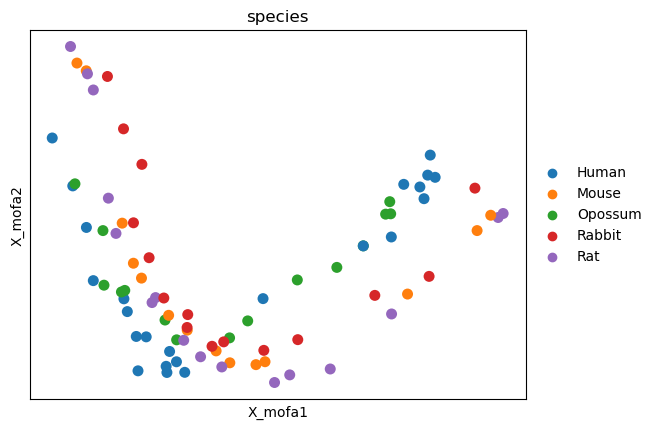

In [26]:
mu.pl.mofa(mdata, color="species", size = 250)

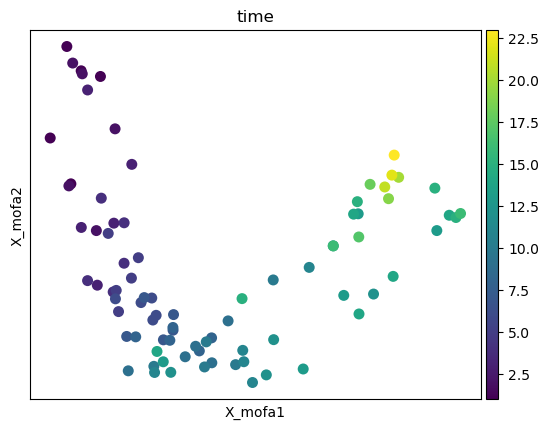

In [27]:
mu.pl.mofa(mdata, color="time", size = 250)

In the previous plot, the samples have been colored according to the time point numbered according to the ordering of the measured samples. However, there have been different numbers of samples collected for each species and also at different time points (since embryonic development e.g. takes much longer in humans than mice). Thus, it is unclear ahead of time which human time point corresponds to what mouse time point. Therefore, MEFISTO also infers the best alignment of time points across species. We can color the above plot with the learned time of each sample in the following and see that the trajectory across the two factors matches to the time information.

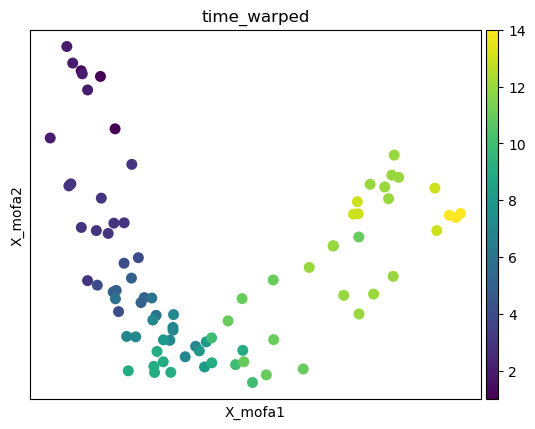

In [28]:
mu.pl.mofa(mdata, color="time_warped", size = 250)

## Alignment

We can also visualize the learned matched time points (`time_warped`) over the original time points. As you can see, for `Human` the highest number of time points (>20) has been measured, but they were then mapped to the corresponding `Mouse` time points (1-14) such that multiple human time points were mapped to the same mouse stage:

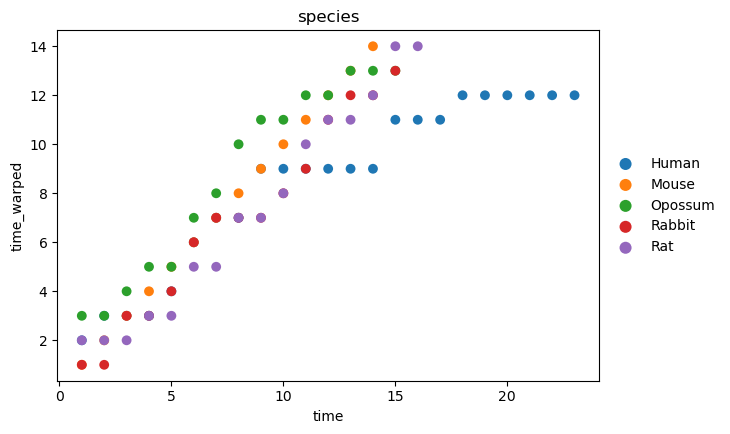

In [29]:
sc.pl.scatter(mdata, x="time", y="time_warped", color="species", size=200)

## Latent factors versus common developmental time
We can also plot the latent processes along the inferred common developmental time.
Before alignment:

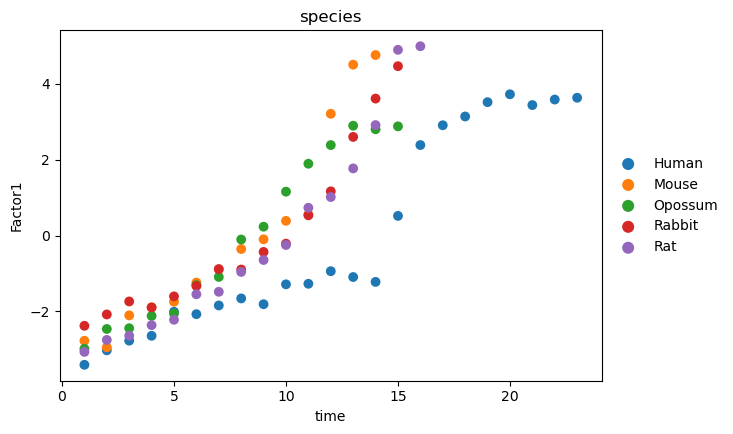

In [30]:
mdata.obs["Factor1"] = mdata.obsm["X_mofa"][:,0]
sc.pl.scatter(mdata, x="time", y="Factor1", color="species", size=200)

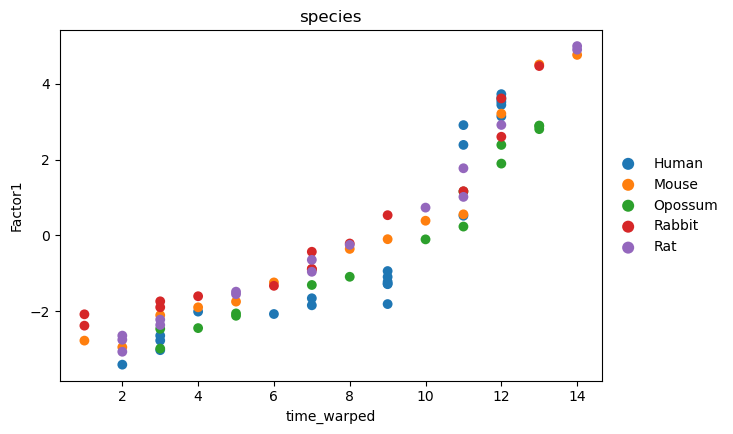

In [31]:
# after alignment
sc.pl.scatter(mdata, x="time_warped", y="Factor1", color="species", size=200)

This plot shows that `Factor1` mostly captures the variability during development which is shared across all species.

## Further analyses
Additionally we can take a look at the smoothness and sharedness of the factors, interpolate the factors or cluster the species based on the learnt group kernel of each latent factor.

For that, we will use the [mofax](https://github.com/bioFAM/mofax) library that provides convenient loaders and plotting functions.

In [32]:
model = mofa.mofa_model("models/mefisto_evodevo.hdf5")
model

MOFA+ model: mefisto evodevo
Samples (cells): 83
Features: 38480
Groups: Human (23), Mouse (14), Opossum (15), Rabbit (15), Rat (16)
Views: Brain (7696), Cerebellum (7696), Heart (7696), Liver (7696), Testis (7696)
Factors: 5
Expectations: Sigma, W, Z

MEFISTO:
Covariates available: time
Interpolated factors for 14 new values

### Interpolation

Using the underlying Gaussian process for each factor we can interpolate to unseen time points for species that are missing data in these time points or intermediate time points.

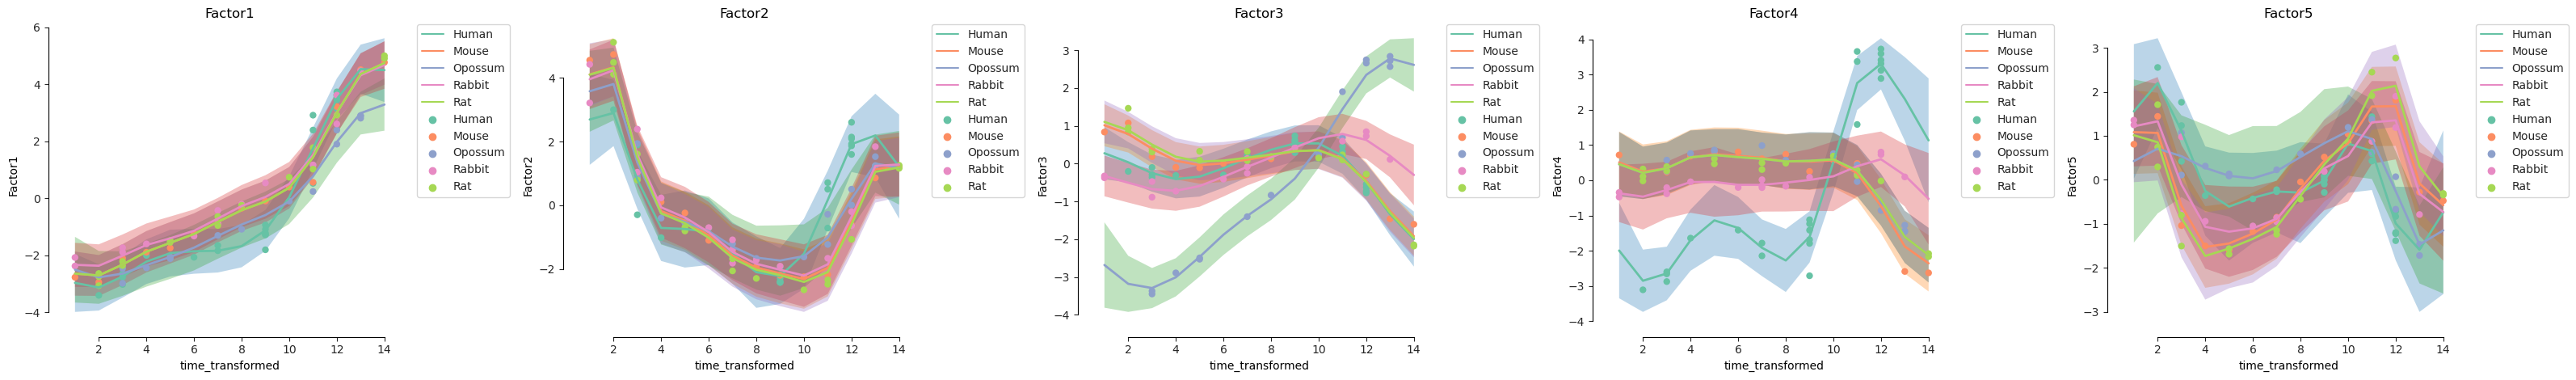

In [33]:
mofa.plot_interpolated_factors(model, factors=range(model.nfactors),
                                ncols=5, size=70);

### Smoothness and sharedness of factors

In addition to the factor values and the alignment the model also inferred an underlying Gaussian process that generated these values. By looking into it we can extract information on the smoothness of each factor, i.e. how smoothly it varies along developmental time, as well as the sharedness of each factor, i.e. how much the species (groups) show the same underlying developmental pattern and how the shape of their developmental trajectory related to a given developmental module (Factor) clusters between species.

The scale parameters of the Gaussian process capture the smoothness of the model. We will visualize them with bar plots where more colour means more smoothness:

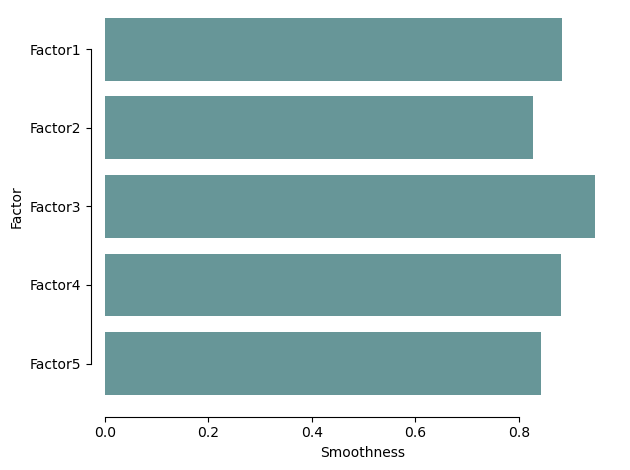

In [34]:
mofa.plot_smoothness(model);

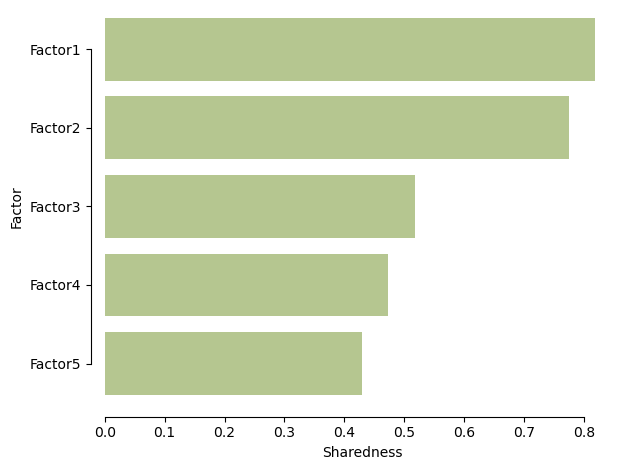

In [35]:
mofa.plot_sharedness(model);

`Factor1` and `Factor2` have the highest amount of sharedness. This also fits to the observations made in the interpolated factors plot, where these factors are very similar across species, whereas `Factor3` e.g. seems to capture a opposom-specific signature over time which is different from the other species.

# Advanced exercise: using pyro to built your own factor model

In the last part of this notebook, we are using `pyro` to built our own Bayesian matrix factorization model and to get a better understanding of how a factor model can be trained using stochastic variational inference. We are implementing a simple factor model that can derive weight matrix $W$ and factor matrix $Z$ from $Y$ ($Y = Z*W^T$). We have $Y^{NxD} = Z^{NxK} * W^{(DxK)T}$ with $N$ samples, $D$ features and $K$ latent factors. We make this matrix factorization Bayesian by adding priors to the matrices $Z$ and $W$.

In [36]:
# Required packages
import pyro
from pyro.nn import PyroSample, PyroModule
from pyro.infer import SVI, Trace_ELBO, autoguide
import torch
from torch.nn.functional import softplus
from sklearn.metrics import mean_squared_error
import random
import matplotlib.pyplot as plt
import seaborn as sns

First, we generate a random factor and weight matrix and use its product for training our model to analyse to what extent the original input can be reconstructed. 

In [37]:
# simulate data
n_obs = 100
n_features = 20
n_factors = 5

torch.manual_seed(2024)
Z_in = torch.randn(n_obs, n_factors) 
W_in = torch.randn(n_features, n_factors) 

# create observated values from the simulated factor and weight matrix with some random noise
Y = torch.matmul(Z_in, W_in.t()) + 0.2 * torch.randn(n_obs, n_features)
print(Y.shape)
print(Y)

torch.Size([100, 20])
tensor([[ 5.3621e-01, -9.5076e-01, -8.2234e-01,  ..., -2.3100e+00,
          1.5223e+00,  4.2384e-01],
        [-8.2410e-01, -2.6438e+00,  5.0057e-01,  ..., -1.6187e+00,
          1.4766e+00, -1.3624e+00],
        [ 3.5991e+00,  8.5626e+00, -1.4502e+00,  ...,  9.4482e-01,
         -1.3726e+00,  1.0173e+00],
        ...,
        [-7.1978e-01, -2.0009e+00,  1.3592e-01,  ..., -6.8602e-01,
          6.1233e-01,  4.7834e-02],
        [-8.2916e-04, -2.9130e+00,  4.6990e-01,  ..., -9.3622e-01,
          9.6277e-02,  7.1257e-01],
        [-9.2778e-01,  2.7502e+00, -1.1326e+00,  ...,  5.6296e+00,
         -1.5591e+00,  2.7615e+00]])


**Excercises:**
1. Training a factor model with 5 latent factors:
    - Use the FA class (in the chunk below) to train a factor model with K = 5 latent factors on the simulated data Y.
    - Plot the loss over the number of steps.
    - Calculate the mean squared error between the input observations Y and an estimate Y_hat based on your factor model (by multiplying the matrix estimates of the trained model).  
2. Identifying the number of latent factors in the data: 
    - Train a factor model on Y with K = 2,3,4,5,6,7 latent factors and calculate for each model the mean squared error.
    - Plot the mean squared error over the number of latent factors. Does the curve fit to your expectations given that we simulated Y with K = 5 factors?  
3. Missing values in the observations: 
    - Create a modified version $Y_{missing}$ of Y in which random entries of the values in Y are missing (set to NA). Set 1, 2.5, 5, 7.5, 10, 15, 20, 25 or 30% of all entries to NA.
    - Train a factor model with K = 5 on each of these modified matrices and calculate its mean squared error.
    - Plot the mean squared error over the percentage of missing values.

In [38]:
class FA(PyroModule):
    def __init__(self, Y, K):
        """
        Args:
            Y: Tensor (Samples x Features)
            K: Number of Latent Factors
        """
        super().__init__()
        pyro.clear_param_store()
        
        # data
        self.Y = Y
        self.K = K
        
        self.num_samples = self.Y.shape[0]
        self.num_features = self.Y.shape[1]
        
        self.sample_plate = pyro.plate("sample", self.num_samples)
        self.feature_plate = pyro.plate("feature", self.num_features)
        self.latent_factor_plate = pyro.plate("latent factors", self.K)
        
        
    def model(self):
        """
        how to generate a matrix
        """
        with self.latent_factor_plate:
            with self.feature_plate:
                # sample weight matrix with Normal prior distribution
                W = pyro.sample("W", pyro.distributions.Normal(0., 1.))                
                
            with self.sample_plate:
                # sample factor matrix with Normal prior distribution
                Z = pyro.sample("Z", pyro.distributions.Normal(0., 1.))
        
        # estimate for Y
        Y_hat = torch.matmul(Z, W.t())
        
        with pyro.plate("feature_", self.Y.shape[1]), pyro.plate("sample_", self.Y.shape[0]):
            # masking the NA values such that they are not considered in the distributions
            obs_mask = torch.ones_like(self.Y, dtype=torch.bool)
            if data is not None:
                obs_mask = torch.logical_not(torch.isnan(self.Y))
            with pyro.poutine.mask(mask=obs_mask):
                if data is not None:
                    # a valid value for the NAs has to be defined even though these samples will be ignored later
                    self.Y = torch.nan_to_num(self.Y, nan=0) 
            
                    # sample scale parameter for each feature-sample pair with LogNormal prior (has to be positive)
                    scale = pyro.sample("scale", pyro.distributions.LogNormal(0., 1.))
                    # compare sampled estimation to the true observation Y
                    pyro.sample("obs", pyro.distributions.Normal(Y_hat, scale), obs=self.Y)


    def train(self):
        # set training parameters
        optimizer = pyro.optim.Adam({"lr": 0.02})
        elbo = Trace_ELBO()
        guide = autoguide.AutoDelta(self.model)
        
        # initialize stochastic variational inference
        svi = SVI(
            model = self.model,
            guide = guide,
            optim = optimizer,
            loss = elbo
        )
        
        num_iterations = 2000
        train_loss = []
        for j in range(num_iterations):
            # calculate the loss and take a gradient step
            loss = svi.step()

            train_loss.append(loss/self.Y.shape[0])
            if j % 200 == 0:
                print("[iteration %04d] loss: %.4f" % (j + 1, loss / self.Y.shape[0]))
        
        # Obtain maximum a posteriori estimates for W and Z
        map_estimates = guide(Y)
        
        return train_loss, map_estimates

## Solution excercise 1

In [39]:
# training a factor model with 5 factors
factor_model = FA(Y = Y, K = 5)
loss, map_estimates = factor_model.train()

[iteration 0001] loss: 114.7042
[iteration 0201] loss: 13.8320
[iteration 0401] loss: 11.0290
[iteration 0601] loss: 10.4524
[iteration 0801] loss: 10.2784
[iteration 1001] loss: 10.2197
[iteration 1201] loss: 10.1982
[iteration 1401] loss: 10.1861
[iteration 1601] loss: 10.1839
[iteration 1801] loss: 10.1802


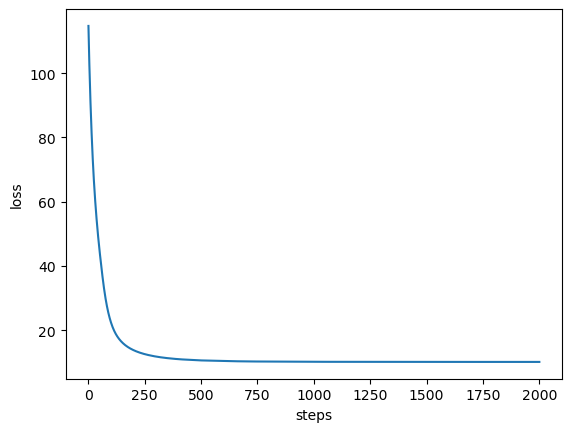

In [40]:
# plotting the loss
df = pd.DataFrame({"steps": np.array([i for i in range(1, 2000+1)]), 
                   "loss":np.array(loss)})

sns.lineplot(df, x="steps", y="loss");

In [41]:
# Obtain maximum a posteriori estimates for the weight and factor matrix
W_hat = map_estimates['W'].detach()
Z_hat = map_estimates['Z'].detach()

# Calculate estimate Y_hat
Y_hat = torch.matmul(Z_hat, W_hat.t())

# Calculate mean squared error
mse = mean_squared_error(Y, Y_hat)
print(mse)

0.03160275


## Solution exercise 2

In [42]:
# Run factor analysis with varying number of factors
mse_results = pd.DataFrame()

for n_factors in [2,3,4,5,6,7]:
    print(f"Factor analysis with {n_factors} latent factors")
    # Train model with n_factors
    factor_model = FA(Y = Y, K = n_factors)
    loss, map_estimates = factor_model.train()

    # Obtain maximum a posteriori estimates for the weight and factor matrix
    W_hat = map_estimates['W'].detach()
    Z_hat = map_estimates['Z'].detach()
    Y_hat = torch.matmul(Z_hat, W_hat.t())
    
    # Calculate MSE
    mse = mean_squared_error(Y, Y_hat)
    mse_results = pd.concat([mse_results, pd.DataFrame({'n_factors': [n_factors], 
                                                        'MSE': [mse]})])

Factor analysis with 2 latent factors
[iteration 0001] loss: 107.2699
[iteration 0201] loss: 41.0695
[iteration 0401] loss: 39.4783
[iteration 0601] loss: 39.1452
[iteration 0801] loss: 39.0239
[iteration 1001] loss: 38.9859
[iteration 1201] loss: 38.9763
[iteration 1401] loss: 38.9646
[iteration 1601] loss: 38.9557
[iteration 1801] loss: 38.9533
Factor analysis with 3 latent factors
[iteration 0001] loss: 109.7713
[iteration 0201] loss: 31.3718
[iteration 0401] loss: 29.3916
[iteration 0601] loss: 28.9734
[iteration 0801] loss: 28.8260
[iteration 1001] loss: 28.7777
[iteration 1201] loss: 28.7586
[iteration 1401] loss: 28.7518
[iteration 1601] loss: 28.7486
[iteration 1801] loss: 28.7446
Factor analysis with 4 latent factors
[iteration 0001] loss: 108.6336
[iteration 0201] loss: 23.0747
[iteration 0401] loss: 20.2282
[iteration 0601] loss: 19.7316
[iteration 0801] loss: 19.5947
[iteration 1001] loss: 19.5439
[iteration 1201] loss: 19.5212
[iteration 1401] loss: 19.5080
[iteration 1601

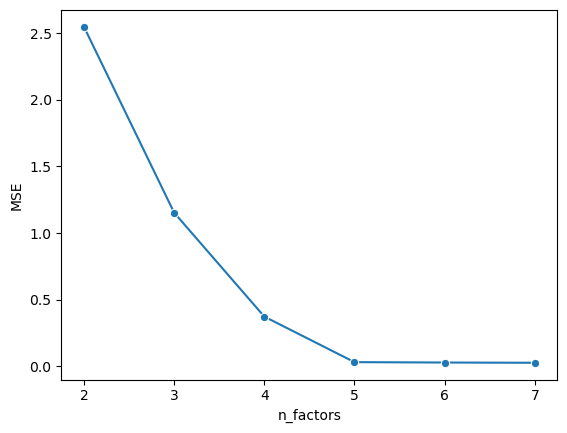

In [43]:
# plot the results
sns.lineplot(mse_results, x = 'n_factors', y = 'MSE', marker='o');

The above plot shows that when a factor model with too few factors is trained, not all of the variability in the data can be captured by those factors such that the difference between the ground truth $Y$ and its estimate is bigger. However, when we train a model with 5 or more factors the error stays nearly the same and is not improved much further. Thus, based on this result plot a model with 5 factors should be chosen which exactly matches the number of factors we used to simulate our data $Y$. 

## Solution Excercise 3

In [44]:
# Function to introduce NA values at random positions
def introduce_na(tensor, na_probability):
    na_tensor = tensor.clone()  # Create a copy of the original tensor
    
    # Get the dimensions of the tensor
    rows, cols = tensor.shape
    
    # Iterate over each element in the tensor
    for i in range(rows):
        for j in range(cols):
            # Generate a random number to decide whether to introduce NA or not
            if random.random() < na_probability:
                na_tensor[i][j] = float('nan')  # Set the value to NA
                
    return na_tensor

In [45]:
mse_results = pd.DataFrame()
for na_prob in [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3]:
    print('NA probability: ' + str(na_prob * 100) +'%')
    Y_missing = introduce_na(Y, na_prob)
    factor_model = FA(Y = Y_missing, K = 5)
    loss, map_estimates = factor_model.train()

    # Obtain maximum a posteriori estimates for the weight and factor matrix
    W_hat = map_estimates['W'].detach()
    Z_hat = map_estimates['Z'].detach()
    Y_hat = torch.matmul(Z_hat, W_hat.t())
    
    # Calculate MSE
    mse = mean_squared_error(Y, Y_hat)
    mse_results = pd.concat([mse_results, pd.DataFrame({'NA_percentage': [na_prob * 100], 
                                                        'MSE': [mse]})])

NA probability: 1.0%
[iteration 0001] loss: 108.7260
[iteration 0201] loss: 14.3490
[iteration 0401] loss: 11.6121
[iteration 0601] loss: 11.0883
[iteration 0801] loss: 10.9562
[iteration 1001] loss: 10.9119
[iteration 1201] loss: 10.8972
[iteration 1401] loss: 10.8907
[iteration 1601] loss: 10.8874
[iteration 1801] loss: 10.8809
NA probability: 2.5%
[iteration 0001] loss: 111.1746
[iteration 0201] loss: 15.5159
[iteration 0401] loss: 12.5683
[iteration 0601] loss: 12.0340
[iteration 0801] loss: 11.8865
[iteration 1001] loss: 11.8356
[iteration 1201] loss: 11.8123
[iteration 1401] loss: 11.7981
[iteration 1601] loss: 11.7949
[iteration 1801] loss: 11.7926
NA probability: 5.0%
[iteration 0001] loss: 107.7917
[iteration 0201] loss: 16.1988
[iteration 0401] loss: 13.3079
[iteration 0601] loss: 12.7465
[iteration 0801] loss: 12.5841
[iteration 1001] loss: 12.5315
[iteration 1201] loss: 12.5140
[iteration 1401] loss: 12.5056
[iteration 1601] loss: 12.5063
[iteration 1801] loss: 12.5032
NA p

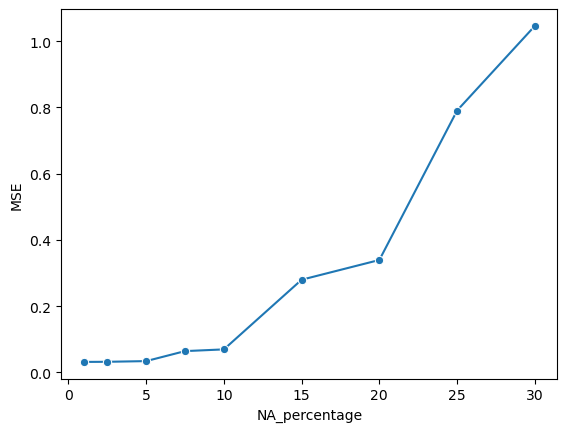

In [46]:
# plot the results
sns.lineplot(mse_results, x = 'NA_percentage', y = 'MSE', marker='o');

When there are up to 10% missing values in the observations $Y$, the factor model is able to impute these missing values very well. However, when more missing values are included the mean squared error is increasing more strongly partly also due to having less observations for training.